In [1]:
import __init__

Navigated to package root: /home/cyprien/CrystaLLMv2_PKV
Added package root to Python path


Note for this study its important that the Material ID is in the base df

In [15]:
import pandas as pd
df = pd.read_parquet('/home/cyprien/Data_Gen/mp-20-data/all_data.parquet')
df

,Material ID,Reduced_Formula,CIF,Split
0,mp-1221227,Na3MnCoNiO6,# generated using pymatgen\ndata_Na3MnCoNiO6\n...,train
1,mp-974729,Nd(Al2Cu)4,# generated using pymatgen\ndata_Nd(Al2Cu)4\n_...,train
2,mp-1185360,LiMnIr2,# generated using pymatgen\ndata_LiMnIr2\n_sym...,train
3,mp-1188861,LiCSN,# generated using pymatgen\ndata_LiCSN\n_symme...,train
4,mp-677272,La2EuS4,# generated using pymatgen\ndata_La2EuS4\n_sym...,train
...,...,...,...,...
45224,mp-21084,In6Ga2PtO8,# generated using pymatgen\ndata_In6Ga2PtO8\n_...,test
45225,mp-571486,CuSe,# generated using pymatgen\ndata_CuSe\n_symmet...,test
45226,mp-14410,Tl6TeO12,# generated using pymatgen\ndata_Tl6TeO12\n_sy...,test
45227,mp-1079192,Sr2GdRuO6,# generated using pymatgen\ndata_Sr2GdRuO6\n_s...,test


In [13]:
!python _utils/_preprocessing/_calculate_XRD.py \
    --input_parquet /home/cyprien/Data_Gen/mp-20-data/all_data.parquet \
    --output_parquet HF-databases/mp_20_pxrd/mp_20_pxrd.parquet \
    --num_workers 16

Loading database from /home/cyprien/Data_Gen/mp-20-data/all_data.parquet
Loaded 45229 entries
Processing XRD patterns for the entries
Generating XRD patterns: 100%|███| 45229/45229 [03:02<00:00, 247.50structures/s]
Computing condition vectors from XRD patterns
Processing XRD patterns: 100%|███| 45229/45229 [00:00<00:00, 45505.59patterns/s]
Theta range: 0-90, Intensity range: 0-100
Saving results to HF-databases/mp_20_pxrd/mp_20_pxrd.parquet
done


In [ ]:
!python _utils/_preprocessing/_cleaning.py \
    --input_parquet HF-databases/mp_20_pxrd/mp_20_pxrd.parquet \
    --output_parquet HF-databases/mp_20_pxrd/mp_20_pxrd_clean.parquet \
    --property_columns "['Condition Vector']" \
    --num_workers 16 \
    --filter_to 1024

Loading data from HF-databases/mp_20_pxrd/mp_20_pxrd.parquet as Parquet with zstd compression...

Normalizing property columns

Lets augment the CIFs now (parallelizing sometimes takes a min before speeding up
Number of CIFs before preprocessing: 45229
Number of workers: 16
100%|███████████████████████████████████| 45229/45229 [00:11<00:00, 3997.55it/s]
Number of CIFs before filtering out bad ones:  45229
Number of CIFs after filtering: 45229

Saving updated dataframe to HF-databases/mp_20_pxrd/mp_20_pxrd_clean.parquet as Parquet with zstd compression...
Preprocessing completed successfully.


In [20]:
!python _utils/_preprocessing/_save_dataset_to_HF.py \
    --input_parquet HF-databases/mp_20_pxrd/mp_20_pxrd_clean.parquet \
    --output_parquet HF-databases/mp_20_pxrd/mp_20_pxrd.parquet \
    --save_hub

Loading Hugging Face API key from API_keys.jsonc
Loading data from HF-databases/mp_20_pxrd/mp_20_pxrd_clean.parquet as Parquet with zstd compression
Splitting dataset according to the 'Split' column
Train columns: ['Material ID', 'Reduced_Formula', 'CIF', 'Condition Vector']
Uploading the dataset shards: 100%|███████████████| 1/1 [00:00<00:00,  1.26it/s]
Dataset saved to Hugging Face Hub as c-bone/mp_20_pxrd


In [ ]:
!python _utils/_generating/make_prompts.py \
    --HF_dataset 'c-bone/mp_20_pxrd' \
    --split 'test' \
    --automatic \
    --output_parquet '_artifacts/mp-20-pxrd/mp-test_prompts.parquet' \
    --level 'level_3' \
    --condition_columns 'Condition Vector'
    # --remove_ref_columns

Loaded 9045 records from c-bone/mp_20_pxrd (test split)

Generated automatic prompts at level_3
Using condition columns: ['Condition Vector']

First 3 rows:
Material ID Reduced_Formula                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

# Ablation studies on a from scratch model

In [1]:
import __init__

Navigated to package root: /home/cyprien/CrystaLLMv2_PKV
Added package root to Python path


In [6]:
import optuna

study = optuna.load_study(
    study_name='mp_20_pxrd_scratch_HPS',
    storage='sqlite:///optuna_hpsearch_mp_20_pxrd_scratch_HPS.db'
)

# 2. Retrieve the best trial
best_trial = study.best_trial

# 3. Access the best hyperparameters and value
best_params = best_trial.params
best_value = best_trial.value

# Print the results
print(f"Best trial value: {best_value}")
print("Best hyperparameters:")
for key, value in best_params.items():
    print(f"    {key}: {value}")

Best trial value: 0.217075377702713
Best hyperparameters:
    cond_dropout: 0.16
    learning_rate: 0.0021071619928203556
    weight_decay: 0.01
    cond_wd: 0.16
    warmup_ratio: 0.09999999999999999
    dropout: 0.18


In [ ]:
!torchrun --nproc_per_node=2 _train.py --config '_config_files/training/conditional/xrd_studies/mp-20-pxrd-slider-scratch-opt.jsonc'

In [9]:
import pandas as pd
import __init__
df = pd.read_parquet('_artifacts/mp-20-pxrd/mp-test_prompts.parquet')

# make a random subset of 1000
df = df.sample(1000, random_state=1).reset_index(drop=True)
df.to_parquet('_artifacts/mp-20-pxrd/mp-test_prompts_1k.parquet', index=False)
# make a no condition version
df['condition_vector'] = df['condition_vector'].apply(lambda x: ','.join(['-100'] * 40))
df.to_parquet('_artifacts/mp-20-pxrd/mp-test_prompts_1k_nocond.parquet', index=False)

#### Look at the impact of perplexity ranking or feeding conditions to outputs

1. Perplexity scoring and xrd conditions
   1. Testing at diff temperatures, top-p = 0.95, top-k = 10, T = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]

In [1]:
import __init__

Navigated to package root: /home/cyprien/CrystaLLMv2_PKV
Added package root to Python path


In [2]:
T = ['050', '075', '100', '125', '150', '175']

In [ ]:
for temp in T:
    gen_config = f"_config_files/generation/conditional/xrd_studies/temp/mp-scratch-20perp-{temp}T_eval.jsonc"
    gen_parquet = f"_artifacts/mp-20-pxrd/temp/mp-20-scratch-20perp-{temp}T_gen.parquet"
    post_parquet = f"_artifacts/mp-20-pxrd/temp/mp-20-scratch-20perp-{temp}_post.parquet"
    metric_20perp_parquet = f"_artifacts/mp-20-pxrd/temp/mp-20-scratch-20perp-{temp}_metrics.parquet"
    metrics_1perp_parquet = f"_artifacts/mp-20-pxrd/temp/mp-20-scratch-1perp-{temp}_metrics.parquet"

    !python _utils/_generating/generate_CIFs.py --config {gen_config}

    !python _utils/_generating/postprocess.py \
    --input_parquet {gen_parquet} \
    --output_parquet {post_parquet} \
    --num_workers 32 

    !python _utils/_metrics/XRD_metrics.py \
    --input_parquet {post_parquet} \
    --num_gens 20 \
    --ref_parquet '_artifacts/mp-20-pxrd/mp-test_ref.parquet' \
    --output_parquet {metric_20perp_parquet} \
    --num_workers 24 \
    --validity_check 'diffcsp'

    !python _utils/_metrics/XRD_metrics.py \
    --input_parquet {post_parquet} \
    --num_gens 1 \
    --ref_parquet '_artifacts/mp-20-pxrd/mp-test_ref.parquet' \
    --output_parquet {metric_1perp_parquet} \
    --num_workers 24 \
    --validity_check 'diffcsp'

In [12]:
import __init__
from _utils import get_metrics_xrd
import pandas as pd

results = {}
for temp in T:
    # if temp == '050':
    #     continue
    metric_20perp_parquet = f"_artifacts/mp-20-pxrd/temp/mp-20-scratch-20perp-{temp}_metrics.parquet"
    metrics_1perp_parquet = f"_artifacts/mp-20-pxrd/temp/mp-20-scratch-1perp-{temp}_metrics.parquet"
    

    df_20perp = pd.read_parquet(metric_20perp_parquet)
    df_1perp = pd.read_parquet(metrics_1perp_parquet)

    results_20perp = get_metrics_xrd(df_20perp, n_test=1000, only_matched=False, verbose=False)
    results_1perp = get_metrics_xrd(df_1perp, n_test=1000, only_matched=False, verbose=False)
    results[temp] = (results_20perp, results_1perp)
    # print("\n")

table_20perp = pd.DataFrame.from_dict({temp: results[temp][0] for temp in results}, orient='index')
table_1perp = pd.DataFrame.from_dict({temp: results[temp][1] for temp in results}, orient='index')

# concatenate the two tables 20perp and 1perp one on top of the other
final_table = pd.concat([table_20perp, table_1perp], axis=0)
final_table.head(12)

,Number of matched structures,Total number of structures,Mean RMS-d,Percent Matched (%),a MAE,b MAE,c MAE,Volume MAE,a R^2,b R^2,c R^2,Volume R^2,Average Score
050,732,1000,0.037880,73.2,0.398910,0.355722,0.613047,22.653828,0.907831,0.923444,0.956180,0.986533,1.150562
075,753,1000,0.039251,75.3,0.375575,0.347693,0.552787,24.130185,0.909784,0.923451,0.960855,0.984487,1.164032
100,764,1000,0.046755,76.4,0.375558,0.359645,0.558239,25.360302,0.911702,0.928448,0.959863,0.982892,1.172248
125,763,1000,0.046011,76.3,0.348746,0.337020,0.513275,26.121423,0.921881,0.929536,0.969376,0.980532,1.176014
150,766,1000,0.053202,76.6,0.320026,0.355575,0.475873,29.193621,0.947918,0.923457,0.980016,0.974556,1.181375
175,762,1000,0.057970,76.2,0.346169,0.358608,0.497896,32.294108,0.931859,0.932192,0.979642,0.972189,1.180569
050,636,1000,0.040839,63.6,0.655451,0.647137,1.003131,26.604039,0.754701,0.803570,0.900085,0.976324,1.136030
075,650,1000,0.046466,65.0,0.700781,0.742220,1.038739,27.955036,0.738067,0.768848,0.894732,0.976672,1.147796
100,632,1000,0.050476,63.2,0.720971,0.813339,1.176208,31.807532,0.729977,0.744414,0.871256,0.972381,1.154265
125,610,1000,0.047291,61.0,0.809757,0.861284,1.233269,31.830606,0.694481,0.737404,0.871876,0.968583,1.154413


1. Perplexity scoring and xrd conditions $\newline$
      2. Now lets see what promting method is best for conditioning

In [ ]:
gen_config = f"_config_files/generation/conditional/xrd_studies/temp/mp-scratch-lvl2-20perp-075T_eval.jsonc"
gen_parquet = f"_artifacts/mp-20-pxrd/temp/mp-20-scratch-lvl2-20perp-075T_gen.parquet"
post_parquet = f"_artifacts/mp-20-pxrd/temp/mp-20-scratch-lvl2-20perp-075_post.parquet"
metric_20perp_parquet = f"_artifacts/mp-20-pxrd/temp/mp-20-scratch-lvl2-20perp-075_metrics.parquet"
metrics_1perp_parquet = f"_artifacts/mp-20-pxrd/temp/mp-20-scratch-lvl2-1perp-075_metrics.parquet"

!python _utils/_generating/generate_CIFs.py --config {gen_config}

!python _utils/_generating/postprocess.py \
--input_parquet {gen_parquet} \
--output_parquet {post_parquet} \
--num_workers 32 

!python _utils/_metrics/XRD_metrics.py \
--input_parquet {post_parquet} \
--num_gens 20 \
--ref_parquet '_artifacts/mp-20-pxrd/mp-test_ref.parquet' \
--output_parquet {metric_20perp_parquet} \
--num_workers 24 \
--validity_check 'diffcsp'

!python _utils/_metrics/XRD_metrics.py \
--input_parquet {post_parquet} \
--num_gens 1 \
--ref_parquet '_artifacts/mp-20-pxrd/mp-test_ref.parquet' \
--output_parquet {metrics_1perp_parquet} \
--num_workers 24 \
--validity_check 'diffcsp'

In [11]:
import __init__
from _utils import get_metrics_xrd
import pandas as pd

# temp = '075'
levels = ['', '-lvl2']
results = {}

for temp in T:
    for level in levels:
        if level == '-lvl2' and temp != '075':
            continue

        metric_20perp_parquet = f"_artifacts/mp-20-pxrd/temp/mp-20-scratch{level}-20perp-{temp}_metrics.parquet"
        metrics_1perp_parquet = f"_artifacts/mp-20-pxrd/temp/mp-20-scratch{level}-1perp-{temp}_metrics.parquet"

        df_20perp = pd.read_parquet(metric_20perp_parquet)
        df_1perp = pd.read_parquet(metrics_1perp_parquet)

        results_20perp = get_metrics_xrd(df_20perp, n_test=1000, only_matched=False, verbose=False)
        results_1perp = get_metrics_xrd(df_1perp, n_test=1000, only_matched=False, verbose=False)
        
        # Use compound key: temp + level
        key = f"{temp}{level}"
        results[key] = (results_20perp, results_1perp)
    
table_20perp = pd.DataFrame.from_dict({key: results[key][0] for key in results}, orient='index')
table_1perp = pd.DataFrame.from_dict({key: results[key][1] for key in results}, orient='index')

final_table = pd.concat([table_20perp, table_1perp], axis=0)
final_table

,Number of matched structures,Total number of structures,Mean RMS-d,Percent Matched (%),a MAE,b MAE,c MAE,Volume MAE,a R^2,b R^2,c R^2,Volume R^2,Average Score
050,732,1000,0.037880,73.2,0.398910,0.355722,0.613047,22.653828,0.907831,0.923444,0.956180,0.986533,1.150562
075,753,1000,0.039251,75.3,0.375575,0.347693,0.552787,24.130185,0.909784,0.923451,0.960855,0.984487,1.164032
075-lvl2,753,1000,0.039035,75.3,0.385666,0.348114,0.541906,23.620074,0.907703,0.922658,0.965036,0.984016,1.150951
100,764,1000,0.046755,76.4,0.375558,0.359645,0.558239,25.360302,0.911702,0.928448,0.959863,0.982892,1.172248
125,763,1000,0.046011,76.3,0.348746,0.337020,0.513275,26.121423,0.921881,0.929536,0.969376,0.980532,1.176014
150,766,1000,0.053202,76.6,0.320026,0.355575,0.475873,29.193621,0.947918,0.923457,0.980016,0.974556,1.181375
175,762,1000,0.057970,76.2,0.346169,0.358608,0.497896,32.294108,0.931859,0.932192,0.979642,0.972189,1.180569
050,636,1000,0.040839,63.6,0.655451,0.647137,1.003131,26.604039,0.754701,0.803570,0.900085,0.976324,1.136030
075,650,1000,0.046466,65.0,0.700781,0.742220,1.038739,27.955036,0.738067,0.768848,0.894732,0.976672,1.147796
075-lvl2,640,1000,0.044178,64.0,0.675019,0.699844,1.072976,25.780397,0.747346,0.790708,0.879127,0.978256,1.139805


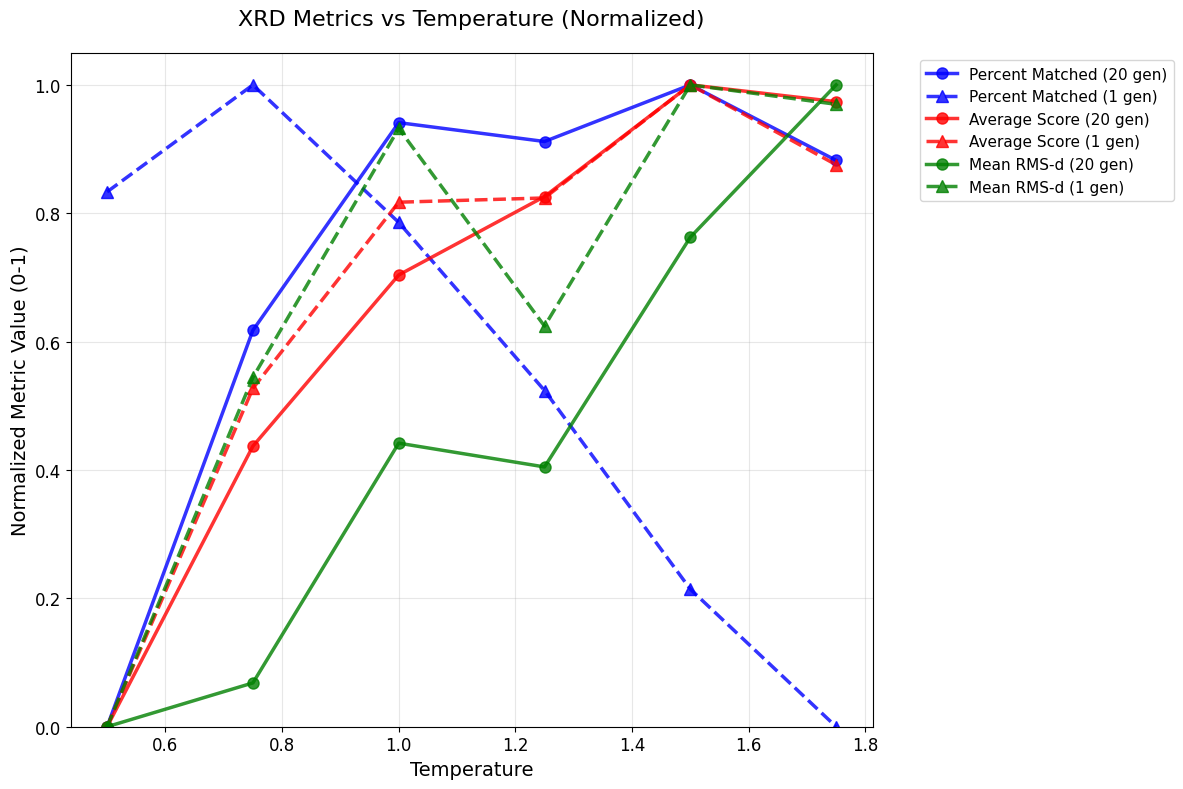

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
temps = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
temp_keys = ['050', '075', '100', '125', '150', '175']

# Helper function to normalize metrics (higher is better after normalization)
def normalize_metric(values, invert=False):
    values = np.array(values)
    if invert:
        # For metrics where lower is better, invert before normalizing
        values = 1.0 / (values)
    min_val, max_val = values.min(), values.max()
    return (values - min_val) / (max_val - min_val) if max_val > min_val else values

# Extract metrics
data = {'20_gen': {'percent': [], 'score': [], 'rmsd': []},
        '1_gen': {'percent': [], 'score': [], 'rmsd': []}}

for temp_key in temp_keys:
    if temp_key in results:
        metrics_20, metrics_1 = results[temp_key]
        
        data['20_gen']['percent'].append(metrics_20['Percent Matched (%)'])
        data['20_gen']['score'].append(metrics_20['Average Score'])
        data['20_gen']['rmsd'].append(metrics_20['Mean RMS-d'])
        
        data['1_gen']['percent'].append(metrics_1['Percent Matched (%)'])
        data['1_gen']['score'].append(metrics_1['Average Score'])
        data['1_gen']['rmsd'].append(metrics_1['Mean RMS-d'])

# Normalize all metrics (invert RMS-d since lower is better)
norm_data = {}
for gen_type in data:
    norm_data[gen_type] = {
        'percent': normalize_metric(data[gen_type]['percent']),
        'score': normalize_metric(data[gen_type]['score']),
        'rmsd': normalize_metric(data[gen_type]['rmsd'], invert=False)
    }


# Create cleaner plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot main metrics with improved styling
colors = {'percent': 'blue', 'score': 'red', 'rmsd': 'green'}
markers = {'20_gen': 'o', '1_gen': '^'}
lines = {'20_gen': '-', '1_gen': '--'}

for metric in ['percent', 'score', 'rmsd']:
    metric_label = {'percent': 'Percent Matched', 'score': 'Average Score', 'rmsd': 'Mean RMS-d'}[metric]
    
    for gen_type in ['20_gen', '1_gen']:
        gen_label = gen_type.replace('_', ' ')
        label = f'{metric_label} ({gen_label})'
        
        ax.plot(temps, norm_data[gen_type][metric], 
               color=colors[metric], marker=markers[gen_type], 
               linestyle=lines[gen_type], linewidth=2.5, markersize=8,
               label=label, alpha=0.8)

ax.set_xlabel('Temperature', fontsize=14)
ax.set_ylabel('Normalized Metric Value (0-1)', fontsize=14)
ax.set_title('XRD Metrics vs Temperature (Normalized)', fontsize=16, pad=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.05)
ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

2. no XRD conditions, no scoring

In [ ]:
!python _utils/_generating/generate_CIFs.py --config '_config_files/generation/conditional/xrd_studies/ablation/mp-xrd-scratch-uncond-20shot_eval.jsonc'

In [ ]:
!python _utils/_generating/postprocess.py \
    --input_parquet '_artifacts/mp-20-pxrd/ablation/mp-20-scratch-uncond-20shot_gen.parquet' \
    --output_parquet '_artifacts/mp-20-pxrd/ablation/mp-20-scratch-uncond-20shot_post.parquet' \
    --num_workers 32 \
    --column_name 'Generated CIF'

In [ ]:
!python _utils/_metrics/XRD_metrics.py \
    --input_parquet '_artifacts/mp-20-pxrd/ablation/mp-20-scratch-uncond-20shot_post.parquet' \
    --num_gens 20 \
    --ref_parquet '_artifacts/mp-20-pxrd/mp-test_ref.parquet' \
    --output_parquet '_artifacts/mp-20-pxrd/ablation/mp-20-scratch-uncond-20shot_metrics.parquet' \
    --num_workers 24 \
    --validity_check 'diffcsp'

In [ ]:
!python _utils/_metrics/XRD_metrics.py \
    --input_parquet '_artifacts/mp-20-pxrd/ablation/mp-20-scratch-uncond-20shot_post.parquet' \
    --num_gens 1 \
    --ref_parquet '_artifacts/mp-20-pxrd/mp-test_ref.parquet' \
    --output_parquet '_artifacts/mp-20-pxrd/ablation/mp-20-scratch-uncond-1shot_metrics.parquet' \
    --num_workers 24 \
    --validity_check 'diffcsp'

3. No scoring, XRD conditions

In [ ]:
!python _utils/_generating/generate_CIFs.py --config '_config_files/generation/conditional/xrd_studies/ablation/mp-xrd-scratch-20shot_eval.jsonc'

In [ ]:
!python _utils/_generating/postprocess.py \
    --input_parquet '_artifacts/mp-20-pxrd/ablation/mp-20-scratch-20shot_gen.parquet' \
    --output_parquet '_artifacts/mp-20-pxrd/ablation/mp-20-scratch-20shot_post.parquet' \
    --num_workers 32 \
    --column_name 'Generated CIF'

In [ ]:
!python _utils/_metrics/XRD_metrics.py \
    --input_parquet '_artifacts/mp-20-pxrd/ablation/mp-20-scratch-20shot_post.parquet' \
    --num_gens 20 \
    --ref_parquet '_artifacts/mp-20-pxrd/mp-test_ref.parquet' \
    --output_parquet '_artifacts/mp-20-pxrd/ablation/mp-20-scratch-20shot_metrics.parquet' \
    --num_workers 24 \
    --validity_check 'diffcsp'

In [29]:
!python _utils/_metrics/XRD_metrics.py \
    --input_parquet '_artifacts/mp-20-pxrd/temp/mp-20-scratch-20perp-075_post.parquet' \
    --num_gens 1 \
    --ref_parquet '_artifacts/mp-20-pxrd/mp-test_ref.parquet' \
    --output_parquet '_artifacts/mp-20-pxrd/temp/mp-20-scratch-1rand-075_metrics.parquet' \
    --num_workers 24 \
    --validity_check 'diffcsp' \
    --sort_gens 'random'

Using 1 generation(s) per compound
Using 32 workers for parallel processing (based on input size)
Randomly selecting one generation per material for num_gens=1
Using 32 workers for parallel processing (based on input size)
Randomly selecting one generation per material for num_gens=1
Loaded 995 materials from _artifacts/mp-20-pxrd/temp/mp-20-scratch-20perp-075_post.parquet
Loaded 995 materials from _artifacts/mp-20-pxrd/temp/mp-20-scratch-20perp-075_post.parquet
Using 995 matched materials from test DB
Parsing true CIFs: 100%|█████████████████████| 995/995 [00:06<00:00, 165.18it/s]
Processing 995 CIFs across 995 materials
Parsing true CIFs: 100%|█████████████████████| 995/995 [00:06<00:00, 165.18it/s]
Processing 995 CIFs across 995 materials
Parsing and sensible check for gen CIFs: 100%|█| 995/995 [00:00<00:00, 1188.90it
Parsing and sensible check for gen CIFs: 100%|█| 995/995 [00:00<00:00, 1188.90it
Materials processed: 995
Materials with sensible structures: 995
Materials processed: 

### Results

In [30]:
metrics_1perp_parquet = "_artifacts/mp-20-pxrd/temp/mp-20-scratch-1perp-075_metrics.parquet"
metrics_20perp_parquet = "_artifacts/mp-20-pxrd/temp/mp-20-scratch-20perp-075_metrics.parquet"
metrics_1rand_parquet = "_artifacts/mp-20-pxrd/temp/mp-20-scratch-1rand-075_metrics.parquet"
metrics_uncond_1shot_parquet = "_artifacts/mp-20-pxrd/ablation/mp-20-scratch-uncond-1shot_metrics.parquet"
metrics_uncond_20shot_parquet = "_artifacts/mp-20-pxrd/ablation/mp-20-scratch-uncond-20shot_metrics.parquet"
metrics_cond_1shot_parquet = "_artifacts/mp-20-pxrd/ablation/mp-20-scratch-1shot_metrics.parquet"
metrics_cond_20shot_parquet = "_artifacts/mp-20-pxrd/ablation/mp-20-scratch-20shot_metrics.parquet"

# make a table with all the results
import __init__
from _utils import get_metrics_xrd
import pandas as pd
import numpy as np

paths = {
    'cond-20perp': metrics_20perp_parquet,
    'cond-1perp': metrics_1perp_parquet,
    'cond-1rand': metrics_1rand_parquet,
    'uncond-20shot': metrics_uncond_20shot_parquet,
    'uncond-1shot': metrics_uncond_1shot_parquet,
    'cond-20shot': metrics_cond_20shot_parquet,
    'cond-1shot': metrics_cond_1shot_parquet
}
results = {}

for names, path in paths.items():
    df = pd.read_parquet(path)
    metrics_result = get_metrics_xrd(df, n_test=1000, only_matched=False, verbose=False)
    results[names] = metrics_result
        
# Create final table with all results
final_table = pd.DataFrame.from_dict(results, orient='index')
final_table

,Number of matched structures,Total number of structures,Mean RMS-d,Percent Matched (%),a MAE,b MAE,c MAE,Volume MAE,a R^2,b R^2,c R^2,Volume R^2,Average Score
cond-20perp,753,1000,0.039251,75.3,0.375575,0.347693,0.552787,24.130185,0.909784,0.923451,0.960855,0.984487,1.164032
cond-1perp,650,1000,0.046466,65.0,0.700781,0.742220,1.038739,27.955036,0.738067,0.768848,0.894732,0.976672,1.147796
cond-1rand,651,1000,0.046270,65.1,0.628617,0.591891,1.011748,28.594334,0.784955,0.825520,0.893046,0.950379,1.162933
uncond-20shot,738,1000,0.042747,73.8,0.445880,0.417049,0.620426,26.121186,0.851922,0.890230,0.949247,0.967401,NaN
uncond-1shot,595,1000,0.058933,59.5,0.758227,0.800942,1.208122,29.194264,0.732321,0.766169,0.849451,0.969499,NaN
cond-20shot,753,1000,0.041790,75.3,0.391880,0.338985,0.551210,24.655743,0.909245,0.929032,0.965629,0.984553,NaN
cond-1shot,628,1000,0.053053,62.8,0.629707,0.661777,0.983864,26.367944,0.805688,0.815377,0.891086,0.979145,NaN
